Code was generated with assistance of colab Gemini AI as well as Dr. Bent's Github tutorial

In [16]:
!pip install pytorch-lightning -q

In [17]:
import os, time, math, json, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
import torch.utils.data as data, torch.optim as optim
import torchvision, torchvision.transforms as transforms
from tqdm.notebook import tqdm

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device: cuda


Load TinyImageNet

In [18]:
import os, zipfile, urllib.request

# Define paths
DATASET_PATH = "data/TinyImageNet"
os.makedirs("data", exist_ok=True)

# Official Stanford TinyImageNet URL (200 classes, 64x64)
url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
zip_path = "data/tiny-imagenet-200.zip"

# Download if missing
if not os.path.exists(zip_path):
    print("Downloading TinyImageNet...")
    urllib.request.urlretrieve(url, zip_path)

# Extract if not already extracted
if not os.path.exists(DATASET_PATH):
    print("Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("data/")
    os.rename("data/tiny-imagenet-200", DATASET_PATH)

print("✅ TinyImageNet ready at:", DATASET_PATH)

✅ TinyImageNet ready at: data/TinyImageNet


In [19]:
import torch
import torchvision.transforms as T
import torch.nn.functional as F
import os, random
import torchvision.models as models
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Create a subset to train on

Total train images available: 100000
Total classes: 200
Selected classes: 200
Selected images (total): 1000 (target ≈ 1000)


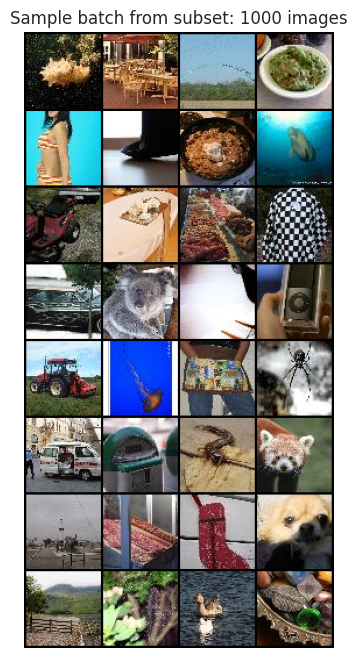

Batch class names: ['n01950731', 'n03201208', 'n04311004', 'n07583066', 'n02837789', 'n04259630', 'n03400231', 'n02074367', 'n03649909', 'n02808440', 'n02927161', 'n03980874', 'n02814533', 'n01882714', 'n04099969', 'n03584254', 'n04465501', 'n01910747', 'n02730930', 'n01774384', 'n03977966', 'n03891332', 'n01784675', 'n02509815', 'n04008634', 'n02927161', 'n03026506', 'n02085620', 'n09332890', 'n04275548', 'n01855672', 'n01768244']


In [20]:
# Select up to N images per class (TinyImageNet train)

random.seed(42)

DATASET_PATH = "data/TinyImageNet"   # adjust if needed
train_dir = os.path.join(DATASET_PATH, "train")
assert os.path.exists(train_dir), f"{train_dir} not found"

# Basic transform (keep images as tensors for display; later use stronger transforms for training)
tf = transforms.Compose([transforms.ToTensor()])

train_ds = datasets.ImageFolder(train_dir, transform=tf)
print("Total train images available:", len(train_ds))
print("Total classes:", len(train_ds.classes))

# Build per-class index lists
indices_per_class = {cls_idx: [] for cls_idx in range(len(train_ds.classes))}
for idx, (path, cls_idx) in enumerate(train_ds.samples):
    indices_per_class[cls_idx].append(idx)

# Sample up to N images per class
N = 5
selected_indices = []
for cls_idx, idx_list in indices_per_class.items():
    if len(idx_list) == 0:
        continue
    # deterministic pick: sort then take first N (or random.sample if you want randomness)
    idx_list_sorted = sorted(idx_list)
    chosen = idx_list_sorted[:N]
    selected_indices.extend(chosen)

selected_indices = sorted(selected_indices)
print("Selected classes:", len(indices_per_class.keys()))
print("Selected images (total):", len(selected_indices), f"(target ≈ {N * len(train_ds.classes)})")

# Create subset and dataloader
subset_ds = Subset(train_ds, selected_indices)
dl = DataLoader(subset_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

# Quick sanity: show a grid of one batch
images, labels = next(iter(dl))
grid = make_grid(images, nrow=4, padding=2)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1,2,0).cpu().numpy().clip(0,1))
plt.axis('off')
plt.title(f"Sample batch from subset: {len(subset_ds)} images")
plt.show()

# Print the (mapped) class names for the batch
# train_ds.classes maps indices -> class_name (folder name)
batch_class_names = [train_ds.classes[int(l)] for l in labels]
print("Batch class names:", batch_class_names)


Load ResNet34

In [21]:
# Load pretrained ResNet34 (ImageNet weights)
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
model.eval()  # freeze
model.to(device)

# Quick test: dummy forward
dummy_img = torch.rand(1,3,64,64).to(device)  # 64x64 matches TinyImageNet
logits = model(dummy_img)
print("Output shape:", logits.shape)  # should be [1,1000]
preprocess = models.ResNet34_Weights.IMAGENET1K_V1.transforms()
loss_module = nn.CrossEntropyLoss()

Output shape: torch.Size([1, 1000])


Visualize and place patch on devil emoji

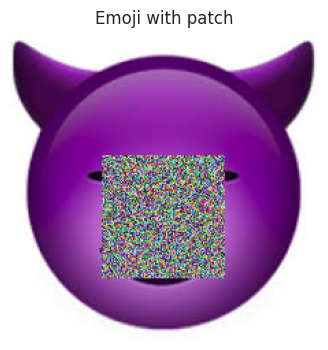

In [22]:
emoji_path = "emoji.jpg"
emoji_img = Image.open(emoji_path).convert("RGB")
H, W = emoji_img.size[1], emoji_img.size[0]

tf = T.ToTensor()
emoji_tensor = tf(emoji_img).to(device)  # [3,H,W]

# Mask for patch
mask = torch.zeros(1, H, W, device=device)
y1, y2 = int(H*0.40), int(H*0.80)
x1, x2 = int(W*0.30), int(W*0.70)
mask[:, y1:y2, x1:x2] = 1.0

# Initialize trainable patch inside mask
patch = torch.rand_like(emoji_tensor) * mask
patch.requires_grad_(True)

# Visualization function
def visualize_emoji_patch(emoji_tensor, patch, mask, title="Emoji with patch"):
    overlay = emoji_tensor.clone()
    overlay[:, y1:y2, x1:x2] = patch[:, y1:y2, x1:x2]
    plt.figure(figsize=(4,4))
    plt.imshow(overlay.detach().cpu().permute(1,2,0).numpy().clip(0,1))
    plt.axis('off')
    plt.title(title)
    plt.show()

visualize_emoji_patch(emoji_tensor, patch, mask)


Patch placing function for training

In [23]:
def prepare_and_place_sticker(batch_imgs, emoji_img, patch, mask, target_size=None):
    """
    Resize sticker to fit batch images, overlay patch in masked region,
    and randomly place sticker+patch on each image.

    Args:
        batch_imgs: [B,3,H_img,W_img] tensor of images
        emoji_img: PIL.Image of sticker/emoji
        patch: [3,H_s,W_s] trainable patch tensor
        mask: [1,H_s,W_s] tensor mask for patch
        target_size: tuple (H_s,W_s) to resize sticker, patch, mask; if None, auto fit to batch

    Returns:
        batch_imgs_with_sticker: [B,3,H_img,W_img] tensor
        resized_patch: resized patch tensor
        resized_mask: resized mask tensor
        resized_sticker: resized sticker tensor
    """
    B, C, H_img, W_img = batch_imgs.shape

    # Determine sticker size
    if target_size is None:
        H_s, W_s = min(emoji_img.size[1], H_img), min(emoji_img.size[0], W_img)
    else:
        H_s, W_s = target_size

    # Resize emoji/sticker
    sticker_resized = T.Resize((H_s, W_s))(emoji_img)  # PIL
    sticker_resized = T.ToTensor()(sticker_resized).to(batch_imgs.device)

    # Resize patch and mask to match sticker
    patch_resized = F.interpolate(patch.unsqueeze(0), size=(H_s, W_s), mode='bilinear', align_corners=False)[0]
    mask_resized = F.interpolate(mask.unsqueeze(0), size=(H_s, W_s), mode='nearest')[0]

    # Prepare output
    out = batch_imgs.clone()

    for i in range(B):
        # random offset
        h_offset = torch.randint(0, H_img - H_s + 1, (1,)).item()
        w_offset = torch.randint(0, W_img - W_s + 1, (1,)).item()

        # place sticker
        out[i, :, h_offset:h_offset+H_s, w_offset:w_offset+W_s] = sticker_resized

        # overlay patch
        region = out[i, :, h_offset:h_offset+H_s, w_offset:w_offset+W_s]
        region = region * (1 - mask_resized) + patch_resized * mask_resized
        out[i, :, h_offset:h_offset+H_s, w_offset:w_offset+W_s] = region

    return out, patch_resized, mask_resized, sticker_resized


Finding class to train on

In [24]:
with open("imagenet_classes.txt", "r") as f:
    categories = [line.strip() for line in f.readlines()]

class_idx = 123
class_name = categories[class_idx]
print(class_name)


spiny lobster


Training Block

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1, Loss: 3.6964


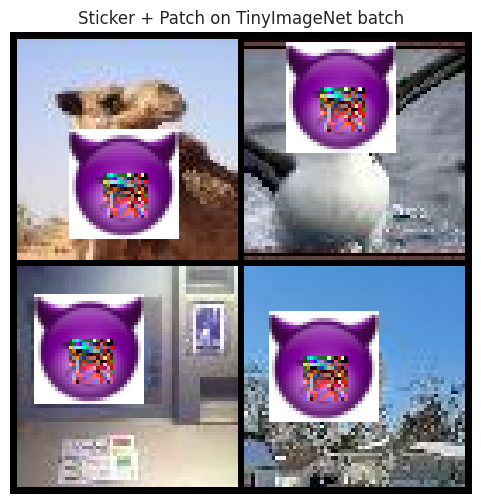

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2, Loss: 1.0249


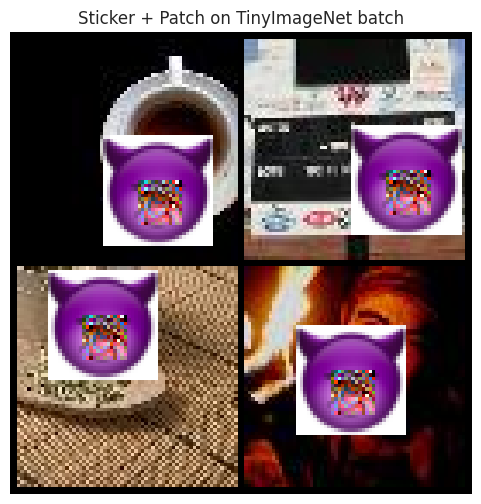

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3, Loss: 0.8325


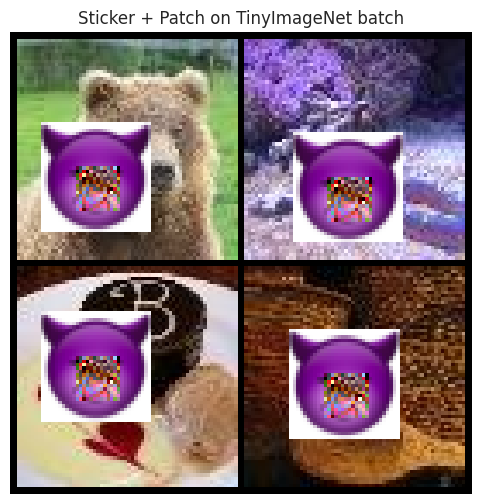

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4, Loss: 0.4799


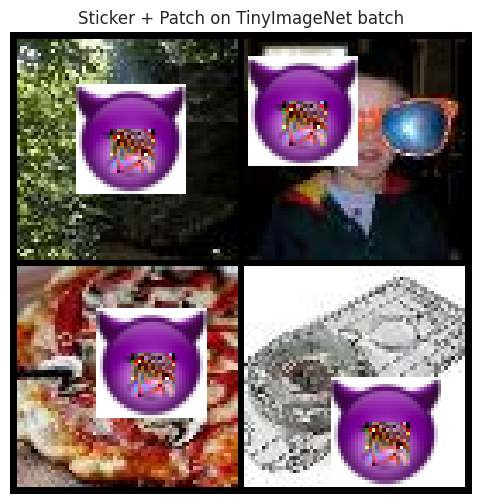

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5, Loss: 0.3352


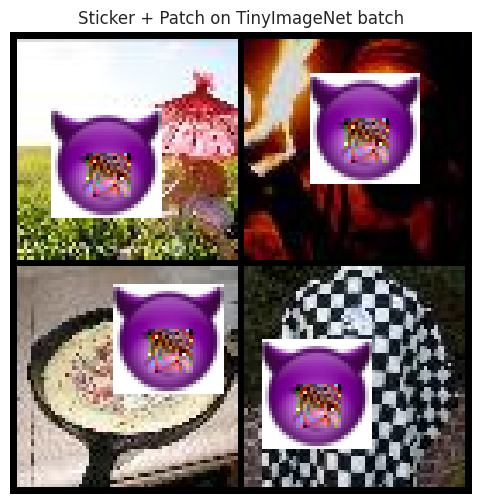

In [25]:
optimizer = torch.optim.Adam([patch], lr=0.1)
num_epochs = 5
target_class = 123
patch.data = torch.rand_like(patch.data) * mask  # new random colors inside mask
patch.data.clamp_(0,1)

for epoch in range(num_epochs):
    t = tqdm(dl, leave=False)
    for imgs, _ in t:
        imgs = imgs.to(device)

        # place sticker + patch
        adv_imgs, patch_resized, mask_resized, sticker_resized = prepare_and_place_sticker(
            batch_imgs=imgs,
            emoji_img=emoji_img,
            patch=patch,
            mask=mask,
            target_size=(32,32)
        )

        # preprocess for ResNet
        adv_imgs_proc = torch.stack([preprocess(img) for img in adv_imgs])

        # forward + loss
        preds = model(adv_imgs_proc)
        labels = torch.zeros(adv_imgs.shape[0], device=device, dtype=torch.long).fill_(target_class)
        loss = loss_module(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # clamp patch values
        with torch.no_grad():
            patch.clamp_(0,1)

        t.set_description(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

    # get a batch
    sample_imgs, _ = next(iter(dl))
    sample_imgs = sample_imgs.to(device)

    # prepare batch with sticker + patch
    adv_imgs, patch_resized, mask_resized, sticker_resized = prepare_and_place_sticker(
        batch_imgs=sample_imgs[:4],
        emoji_img=emoji_img,
        patch=patch,
        mask=mask,
        target_size=(32,32)
    )

    # visualize
    from torchvision.utils import make_grid
    grid = make_grid(adv_imgs, nrow=2)
    plt.figure(figsize=(6,6))
    plt.imshow(grid.detach().cpu().permute(1,2,0).numpy().clip(0,1))
    plt.axis('off')
    plt.title("Sticker + Patch on TinyImageNet batch")
    plt.show()



Building Validation Data

Selected 200 images (1 per class) for testing


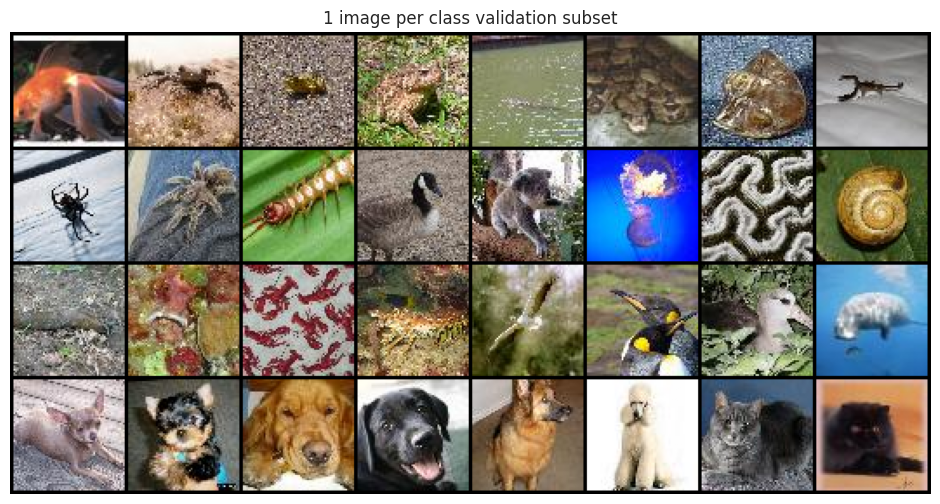

Batch class names: ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01855672', 'n01882714', 'n01910747', 'n01917289', 'n01944390', 'n01945685', 'n01950731', 'n01983481', 'n01984695', 'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02085620', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799', 'n02123045', 'n02123394']


In [26]:
# --- 1. Build per-class indices ---

VAL_DIR = "data/TinyImageNet/val/processed"  # adjust path if needed
tf = transforms.Compose([transforms.ToTensor()])  # basic tensor transform

val_ds = datasets.ImageFolder(VAL_DIR, transform=tf)
indices_per_class = {cls_idx: [] for cls_idx in range(len(val_ds.classes))}
for idx, (path, cls_idx) in enumerate(val_ds.samples):
    indices_per_class[cls_idx].append(idx)

# --- 2. Pick 1 image per class ---
selected_indices = [idx_list[0] for idx_list in indices_per_class.values() if len(idx_list) > 0]
print(f"Selected {len(selected_indices)} images (1 per class) for testing")

# --- 3. Create subset and DataLoader ---
subset_val = Subset(val_ds, selected_indices)
subset_loader = DataLoader(subset_val, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# --- 4. Quick visualization ---
imgs, labels = next(iter(subset_loader))
grid = make_grid(imgs, nrow=8, padding=2)
plt.figure(figsize=(12,6))
plt.imshow(grid.permute(1,2,0).cpu().numpy().clip(0,1))
plt.axis('off')
plt.title("1 image per class validation subset")
plt.show()

batch_class_names = [val_ds.classes[int(l)] for l in labels]
print("Batch class names:", batch_class_names)

Seeing Results

Attack success top1: 0.884, top5: 1.000 (176/199, 199/199)
00: predicted=123 (spiny lobster), true=0 (tench)
01: predicted=123 (spiny lobster), true=1 (goldfish)
02: predicted=123 (spiny lobster), true=2 (great white shark)
03: predicted=123 (spiny lobster), true=3 (tiger shark)
04: predicted=123 (spiny lobster), true=4 (hammerhead)
05: predicted=123 (spiny lobster), true=5 (electric ray)
06: predicted=123 (spiny lobster), true=6 (stingray)
07: predicted=73 (barn spider), true=7 (cock)
08: predicted=123 (spiny lobster), true=8 (hen)
09: predicted=123 (spiny lobster), true=9 (ostrich)
10: predicted=79 (centipede), true=10 (brambling)
11: predicted=125 (hermit crab), true=11 (goldfinch)
12: predicted=123 (spiny lobster), true=12 (house finch)
13: predicted=123 (spiny lobster), true=13 (junco)
14: predicted=123 (spiny lobster), true=14 (indigo bunting)
15: predicted=123 (spiny lobster), true=15 (robin)
16: predicted=123 (spiny lobster), true=16 (bulbul)
17: predicted=123 (spiny lobster), 

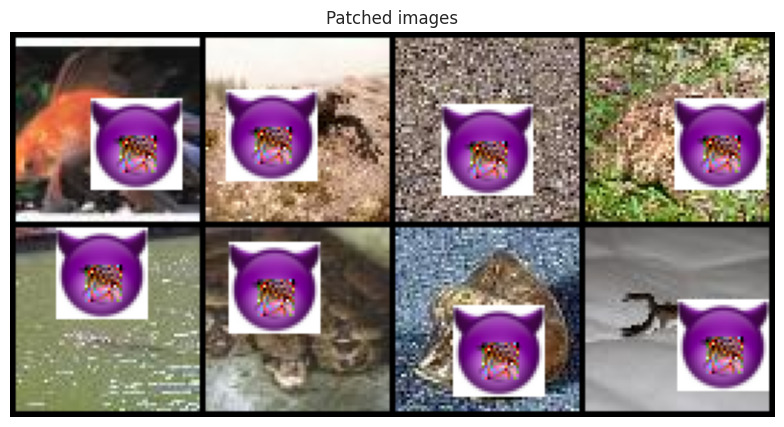

In [27]:
# SETTINGS
TARGET_CLASS = 123
STICKER_SIZE = (32,32)
VISUALIZE_N = 8

# preprocess
from torchvision import models

weights = models.ResNet34_Weights.IMAGENET1K_V1
preprocess = weights.transforms()

def place_patch_on_sticker(imgs, sticker, patch, mask, size=STICKER_SIZE):
    B, C, H_img, W_img = imgs.shape
    sticker_resized = T.ToTensor()(T.Resize(size)(sticker)).to(imgs.device)
    patch_r = F.interpolate(patch.unsqueeze(0), size=size, mode='bilinear')[0]
    mask_r = F.interpolate(mask.unsqueeze(0), size=size, mode='nearest')[0]
    out = imgs.clone()
    H_s, W_s = size

    if H_img - H_s <= 0 or W_img - W_s <= 0:
        raise ValueError(f"Sticker size {size} larger than image {(H_img,W_img)}")

    for i in range(B):
        h_off = torch.randint(0, H_img - H_s + 1, (1,)).item()
        w_off = torch.randint(0, W_img - W_s + 1, (1,)).item()
        # place sticker
        out[i,:,h_off:h_off+H_s, w_off:w_off+W_s] = sticker_resized
        region = out[i,:,h_off:h_off+H_s, w_off:w_off+W_s]
        # overlay patch
        out[i,:,h_off:h_off+H_s, w_off:w_off+W_s] = region*(1-mask_r) + patch_r*mask_r
    return out

# EVAL
model.eval()
top1, top5, total = 0,0,0
pred_majorities = []
with torch.no_grad():
    for imgs, labels in subset_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        B = imgs.shape[0]

        # Perform a single placement
        adv = place_patch_on_sticker(imgs, emoji_img, patch, mask)
        adv_proc = torch.stack([preprocess(to_pil_image(im)) for im in adv]).to(device)
        logits = model(adv_proc)
        preds = logits.argmax(1)
        top5_preds = logits.topk(5,1).indices

        # Evaluate based on the single placement
        valid = (labels!=TARGET_CLASS)
        top1 += ((preds==TARGET_CLASS)&valid).sum().item()
        top5 += ((top5_preds==TARGET_CLASS).any(1)&valid).sum().item()
        total += valid.sum().item()

        for i in range(B):
            pred_majorities.append((int(preds[i].cpu()),int(labels[i].cpu())))

# RESULTS
print(f"Attack success top1: {top1/total:.3f}, top5: {top5/total:.3f} ({top1}/{total}, {top5}/{total})")
for i,(pred,true) in enumerate(pred_majorities):
    print(f"{i:02d}: predicted={pred} ({categories[pred]}), true={true} ({categories[true]})")

# SIMPLE VISUALIZATION
sample_imgs,_ = next(iter(subset_loader))
patched_vis = place_patch_on_sticker(sample_imgs[:VISUALIZE_N].to(device), emoji_img, patch, mask)
grid = make_grid(patched_vis.cpu(), nrow=4)
plt.figure(figsize=(10,5))
plt.imshow(grid.permute(1,2,0).clip(0,1))
plt.axis('off')
plt.title("Patched images")
plt.show()